## Loading raw gene counts into dataframe

In [61]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
df_mostcommon1 = pd.read_table('mostcommon1.htseq.counts.txt')
df_mostcommon2 = pd.read_table('mostcommon2.htseq.counts.txt')
df_mostcommon3 = pd.read_table('mostcommon3.htseq.counts.txt')
df_leastcommon1 = pd.read_table('leastcommon1.htseq_counts.txt')
df_leastcommon2 = pd.read_table('leastcommon2.htseq_counts.txt')
df_leastcommon3 = pd.read_table('leastcommon3.htseq_counts.txt')

In [63]:
df = df_mostcommon1.merge(df_mostcommon2,'outer','id').merge(df_mostcommon3,'outer','id').merge(df_leastcommon1,'outer','id').merge(df_leastcommon2,'outer','id').merge(df_leastcommon3,'outer','id')
df.head()

,id,mc_1,mc_2,mc_3,lc_1,lc_2,lc_3
0,ENSG00000000003.13,3994,2283,5112,274,74,14
1,ENSG00000000005.5,2377,11,47,116,32,0
2,ENSG00000000419.11,1483,3387,4822,1445,473,0
3,ENSG00000000457.12,1248,1998,1185,1447,348,0
4,ENSG00000000460.15,239,1089,3734,2184,209,0


## Verifying most genes not differentially expressed with histogram plots of ratios

In [66]:
df['geo_mean'] = np.sqrt(df['mc_1']*df['lc_1'])
df['mc_1_ratios'] = df['mc_1']/df['geo_mean']
df['lc_1_ratios'] = df['lc_1']/df['geo_mean']

In [67]:
df[df['mc_1_ratios'] < 10000]['mc_1_ratios'].median()

1.1338934190276817

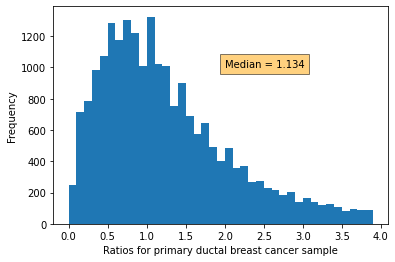

In [68]:
plt.hist(df[df['mc_1_ratios'] < 10000]['mc_1_ratios'],bins=[i/10 for i in range (40)])
plt.xlabel("Ratios for primary ductal breast cancer sample")
plt.ylabel("Frequency")

plt.text(2,1000,"Median = 1.134",bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 5})
plt.show()

In [69]:
df[df['lc_1_ratios'] < 10000]['lc_1_ratios'].median()

0.8819171036881969

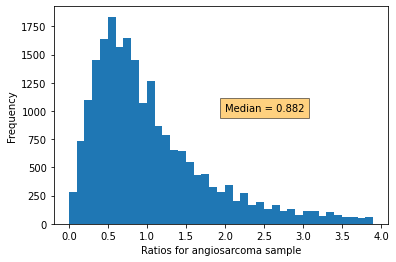

In [70]:
plt.hist(df[df['lc_1_ratios'] < 10000]['lc_1_ratios'],bins=[i/10 for i in range (40)])
plt.xlabel("Ratios for angiosarcoma sample")
plt.ylabel("Frequency")

plt.text(2,1000,"Median = 0.882",bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 5})
plt.show()

## Data preprocessing for DESeq gene expression analysis 

In [72]:
df = df.drop(labels=['geo_mean','mc_1_ratios','lc_1_ratios'],axis=1)
sample_df = pd.DataFrame({'samplename': df.columns}) \
        .query('samplename != "id"')\
        .assign(sample = lambda d: d.samplename.str.extract('([ml]c)_', expand=False)) \
        .assign(replicate = lambda d: d.samplename.str.extract('_([123])', expand=False)) 
sample_df.index = sample_df.samplename
sample_df

,samplename,sample,replicate
samplename,,,
mc_1,mc_1,mc,1
mc_2,mc_2,mc,2
mc_3,mc_3,mc,3
lc_1,lc_1,lc,1
lc_2,lc_2,lc,2
lc_3,lc_3,lc,3


In [73]:
from diffexpr.py_deseq import py_DESeq2

dds = py_DESeq2(count_matrix = df,
               design_matrix = sample_df,
               design_formula = '~ replicate + sample',
               gene_column = 'id') # <- telling DESeq2 this should be the gene ID column
    
dds.run_deseq() 
dds.get_deseq_result(contrast = ['sample','mc','lc'])
res = dds.deseq_result
res.head()







INFO:DESeq2:Using contrast: ['sample', 'mc', 'lc']


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,id
ENSG00000000003.13,820.983313,2.878645,1.047790,2.747350,0.006008,0.037182,ENSG00000000003.13
ENSG00000000005.5,211.020812,1.102680,1.526393,0.722409,0.470043,0.644708,ENSG00000000005.5
ENSG00000000419.11,809.022387,1.634711,1.382216,1.182674,0.236938,0.416514,ENSG00000000419.11
ENSG00000000457.12,486.402116,1.152420,1.303157,0.884329,0.376519,0.559944,ENSG00000000457.12
ENSG00000000460.15,558.459257,0.395425,1.500216,0.263579,0.792104,0.880028,ENSG00000000460.15


## Visualizing results

In [74]:
import bioinfokit
from bioinfokit import analys, visuz

In [75]:
df = res.drop(labels=['baseMean','lfcSE','stat','padj'],axis=1)
df = df.dropna(subset=['log2FoldChange'])

In [83]:
df.head()

,log2FoldChange,pvalue,id
ENSG00000000003.13,2.878645,0.006008,ENSG00000000003.13
ENSG00000000005.5,1.102680,0.470043,ENSG00000000005.5
ENSG00000000419.11,1.634711,0.236938,ENSG00000000419.11
ENSG00000000457.12,1.152420,0.376519,ENSG00000000457.12
ENSG00000000460.15,0.395425,0.792104,ENSG00000000460.15


In [76]:
len(df[df['log2FoldChange'] > 0])

19140

In [77]:
len(df[df['log2FoldChange'] < 0])

22340

In [78]:
min_pvalues = []

for i in range(30):

    min_pvalues.append(df.pvalue.nsmallest(i+1).iloc[-1])
    
min_pvalues_genesIDs = []

for pvalue in min_pvalues:
    
    min_pvalues_genesIDs.append(df[df['pvalue'] == pvalue].index[0])

In [79]:
geneID_to_name = dict()

geneID_to_name.update([('ENSG00000200087.1','SNORA73B')])
geneID_to_name.update([('ENSG00000238741.1','SCARNA7')])
geneID_to_name.update([('ENSG00000198712.1','MT-CO2')])
geneID_to_name.update([('ENSG00000198804.2','MT-CO1')])
geneID_to_name.update([('ENSG00000198763.3','MT-ND2')])
geneID_to_name.update([('ENSG00000198899.2','MT-ATP6')])
geneID_to_name.update([('ENSG00000252010.1','SCARNA5')])
geneID_to_name.update([('ENSG00000215156.5','AC138409.1')])
geneID_to_name.update([('ENSG00000198727.2','MT-CYB')])
geneID_to_name.update([('ENSG00000198888.2','MT-ND1')])
geneID_to_name.update([('ENSG00000212232.1','SNORD17')])
geneID_to_name.update([('ENSG00000198938.2','MT-CO3')])
geneID_to_name.update([('ENSG00000198886.2','MT-ND4')])
geneID_to_name.update([('ENSG00000199477.1','SNORA31')])
geneID_to_name.update([('ENSG00000198840.2','MT-ND3')])
geneID_to_name.update([('ENSG00000212402.1','SNORA74B')])
geneID_to_name.update([('ENSG00000207445.1','SNORD15B')])
geneID_to_name.update([('ENSG00000198695.2','MT-ND6')])
geneID_to_name.update([('ENSG00000212907.2','MT-ND4L')])
geneID_to_name.update([('ENSG00000143520.6','FLG2')])
geneID_to_name.update([('ENSG00000221491.2','SNORA2C')])
geneID_to_name.update([('ENSG00000198786.2','MT-ND5')])
geneID_to_name.update([('ENSG00000208892.1','SNORA49')])
geneID_to_name.update([('ENSG00000251733.1','SCARNA8')])
geneID_to_name.update([('ENSG00000200354.1','SNORA71D')])
geneID_to_name.update([('ENSG00000228253.1','MT-ATP8')])
geneID_to_name.update([('ENSG00000248527.1','MTATP6P1')])
geneID_to_name.update([('ENSG00000212283.1','SNORD89')])
geneID_to_name.update([('ENSG00000200959.1','SNORA74A')])
geneID_to_name.update([('ENSG00000233974.3','AC138951.1')])

In [80]:
visuz.gene_exp.volcano(df=df, lfc='log2FoldChange', pv='pvalue',lfc_thr=(8, 8),pv_thr=(0.00000000001, 0.00000000001), geneid='id', genenames=geneID_to_name, gstyle=2,sign_line=True)